# DSC510 Group Project: Ames Housing Dataset

## Authors

- Marios Theofanous
- Antonis Alexandrou
- Ioannis Demetriou

## Abstract

The housing market is a key domain within real estate and economics, where
understanding property values plays an important role for buyers, sellers, investors,
and policymakers. A complex mix of factors are influencing the prices, for example
location, physical characteristics, neighborhood amenities, and economic conditions.
Accurately estimating a property’s value can help stakeholders make informed
decisions, optimize investments, and improve affordability analyses.

In [22]:
# Importing Libraries

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_palette("viridis")

## Dataset

The analysis will use the "Ames Housing Dataset
" dataset obtained from
[here](https://www.kaggle.com/datasets/prevek18/ames-housing-dataset)
at the time of writing. 

In this section we will load and inspect the dataset, make a preliminary inspection for missing data and
prepare it for analysis by casting to appropriate types and other feature engineering.


### Load Dataset

In [23]:
# original = pd.read_csv('./data/AmesHousing.csv', keep_default_na=False, na_values=['', ' ', 'na', 'NA', 'N/A']) # Specify list because "None" is valid
original = pd.read_csv('./data/AmesHousing.csv')
original

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


### Dataset Shape & Feature Types

Our dataset contains a relatively large number of features. We need to understand what type they are - quantitative or qualitative, and if the latter, ordinal or categorical.

In [24]:
rows, cols = original.shape
print(f"Dataset shape: {rows} rows × {cols} columns")

Dataset shape: 2930 rows × 82 columns


In [25]:
# Here we print all of the features with their current type and intigative 5 example values
print(
    original.head().T.assign(types=original.dtypes.values).to_string()
)

                         0          1          2          3          4    types
Order                    1          2          3          4          5    int64
PID              526301100  526350040  526351010  526353030  527105010    int64
MS SubClass             20         20         20         20         60    int64
MS Zoning               RL         RH         RL         RL         RL   object
Lot Frontage         141.0       80.0       81.0       93.0       74.0  float64
Lot Area             31770      11622      14267      11160      13830    int64
Street                Pave       Pave       Pave       Pave       Pave   object
Alley                  NaN        NaN        NaN        NaN        NaN   object
Lot Shape              IR1        Reg        IR1        Reg        IR1   object
Land Contour           Lvl        Lvl        Lvl        Lvl        Lvl   object
Utilities           AllPub     AllPub     AllPub     AllPub     AllPub   object
Lot Config          Corner     Inside   

The description of what each feature describes is available [here](https://cran.r-project.org/web/packages/AmesHousing/AmesHousing.pdf)

- `Order`: Observation number
- `PID`: Parcel identification number - can be used with city web site for parcel review.
- `MS SubClass`: Identifies the type of dwelling involved in the sale.
- `MS Zoning`: Identifies the general zoning classification of the sale.
- `Lot Frontage`: Linear feet of street connected to property
- `Lot Area`: Lot size in square feet
- `Street`: Type of road access to property
- `Alley`: Type of alley access to property
- `Lot Shape`: General shape of property
- `Land Contour`: Flatness of the property
- `Utilities`: Type of utilities available
- `Lot Config`: Lot configuration
- `Land Slope`: Slope of property
- `Neighborhood`: Physical locations within Ames city limits (map available)
- `Condition 1`: Proximity to various conditions
- `Condition 2`: Proximity to various conditions (if more than one is present)
- `Bldg Type`: Type of dwelling
- `House Style`: Style of dwelling
- `Overall Qual`: Rates the overall material and finish of the house
- `Overall Cond`: Rates the overall condition of the house
- `Year Built`: Original construction date
- `Year Remod/Add`: Remodel date (same as construction date if no remodeling or additions)
- `Roof Style`: Type of roof
- `Roof Matl`: Roof material
- `Exterior 1`: Exterior covering on house
- `Exterior 2`: Exterior covering on house (if more than one material)
- `Mas Vnr Type`: Masonry veneer type
- `Mas Vnr Area`: Masonry veneer area in square feet
- `Exter Qual`: Evaluates the quality of the material on the exterior
- `Exter Cond`: Evaluates the present condition of the material on the exterior
- `Foundation`: Type of foundation
- `Bsmt Qual`: Evaluates the height of the basement
- `Bsmt Cond`: Evaluates the general condition of the basement
- `Bsmt Exposure`: Refers to walkout or garden level walls
- `BsmtFin Type 1`: Rating of basement finished area
- `BsmtFin SF 1`: Type 1 finished square feet
- `BsmtFinType 2`: Rating of basement finished area (if multiple types)
- `BsmtFin SF 2`: Type 2 finished square feet
- `Bsmt Unf SF`: Unfinished square feet of basement area
- `Total Bsmt SF`: Total square feet of basement area
- `Heating`: Type of heating
- `HeatingQC`: Heating quality and condition
- `Central Air`: Central air conditionisng
- `Electrical`: Electrical system
- `1st Flr SF`: First Floor square feet
- `2nd Flr SF`: Second floor square feet
- `Low Qual Fin SF`: Low quality finished square feet (all floors)
- `Gr Liv Area`: Above grade (ground) living area square feet
- `Bsmt Full Bath`: Basement full bathrooms
- `Bsmt Half Bath`: Basement half bathrooms
- `Full Bath`: Full bathrooms above grade
- `Half Bath`: Half baths above grade
- `Bedroom`: Bedrooms above grade (does NOT include basement bedrooms)
- `Kitchen`: Kitchens above grade
- `KitchenQual`: Kitchen quality
- `TotRmsAbvGrd`: Total rooms above grade (does not include bathrooms)
- `Functional`: Home functionality (Assume typical unless deductions are warranted)
- `Fireplaces`: Number of fireplaces
- `FireplaceQu`: Fireplace quality
- `Garage Type`: Garage location
- `Garage Yr Blt`: Year garage was built
- `Garage Finish`: Interior finish of the garage
- `Garage Cars`: Size of garage in car capacity
- `Garage Area`: Size of garage in square feet
- `Garage Qual`: Garage quality
- `Garage Cond`: Garage condition
- `Paved Drive`: Paved driveway
- `Wood Deck SF`: Wood deck area in square feet
- `Open Porch SF`: Open porch area in square feet
- `Enclosed Porch`: Enclosed porch area in square feet
- `3-Ssn Porch`: Three season porch area in square feet
- `Screen Porch`: Screen porch area in square feet
- `Pool Area`: Pool area in square feet
- `Pool QC`: Pool quality
- `Fence`: Fence quality
- `Misc Feature`: Miscellaneous feature not covered in other categories
- `Misc Val`: $Value of miscellaneous feature
- `Mo Sold`: Month Sold
- `Yr Sold`: Year Sold
- `Sale Type`: Type of sale
- `Sale Condition`: Condition of sale

### Unique Identifier

The dataset contains two fields that could potentially be used to identify the properties: `Order` and `PID`. From domain knowledge, `PID` means "Parcel ID" - a term used in land registry to identify properties.

To verify its uniqueness across the dataset, we count the unique `PID` entries and compare against total rows.

We will then drop the `Order` column and set `PID` as index.

In [26]:
if original.PID.nunique() == original.shape[0]:
    print('PID only contains unique entries')

PID only contains unique entries


In [27]:
# Drop 'Order', set PID as index
df = original.drop(columns="Order")
df = df.set_index("PID")
df.head().T

PID,526301100,526350040,526351010,526353030,527105010
MS SubClass,20,20,20,20,60
MS Zoning,RL,RH,RL,RL,RL
Lot Frontage,141.0,80.0,81.0,93.0,74.0
Lot Area,31770,11622,14267,11160,13830
Street,Pave,Pave,Pave,Pave,Pave
...,...,...,...,...,...
Mo Sold,5,6,6,4,3
Yr Sold,2010,2010,2010,2010,2010
Sale Type,WD,WD,WD,WD,WD
Sale Condition,Normal,Normal,Normal,Normal,Normal


### Feature Encoding

We will now cast the features into types pandas and any other frameworks we can use will be able to process.

In particular we want to cast temporal features to datetime, and features that make sense as qualitative as ordinals or simply categories.

In [36]:
# Convert temporal data to DateTime object
df['Date Sold'] = pd.to_datetime({'year': df['Yr Sold'], 'month': df['Mo Sold'], 'day': 1})

df['Garage Yr Blt'] = pd.to_datetime({'year': df['Garage Yr Blt'], 'month': 1, 'day': 1})
df['Year Built'] = pd.to_datetime({'year': df['Year Built'], 'month': 1, 'day': 1})
df['Year Remod/Add'] = pd.to_datetime({'year': df['Year Remod/Add'], 'month': 1, 'day': 1})

# TODO: Calculate age?
# NEW CODE
# House age at the time of sale
df['House Age'] = (df['Date Sold'] - df['Year Built']).dt.days / 365

# Years since last remodel until the sale
df['Since Remodel'] = (df['Date Sold'] - df['Year Remod/Add']).dt.days / 365

df['House Age'] = df['House Age'].round(1)
df['Since Remodel'] = df['Since Remodel'].round(1)

print(df[['House Age', 'Since Remodel']].head(10))

           House Age  Since Remodel
PID                                
526301100       50.4           50.4
526350040       49.4           49.4
526351010       52.4           52.4
526353030       42.3           42.3
527105010       13.2           12.2
527105030       12.4           12.4
527127150        9.3            9.3
527145080       18.0           18.0
527146030       15.2           14.2
527162130       11.4           11.4


In [38]:
# We could either drop the original ones or consider them as categorical
# df.drop(columns=['Mo Sold', 'Yr Sold'], inplace=True)
df['Mo Sold'] = df['Mo Sold'].astype("category")
df['Yr Sold'] = df['Yr Sold'].astype("category")

In [9]:
# Cast between integers and floats
# Features like areas makes sense to be of type float as they could contain decimal (even though our dataset does not)
# Other features that are discrete like number of rooms should be ints
df['Garage Cars'] = df['Garage Cars'].astype('Int64') # Parser considers them as float (because of missing values?)
df['Bsmt Full Bath'] = df['Bsmt Full Bath'].astype('Int64')
df['Bsmt Half Bath'] = df['Bsmt Half Bath'].astype('Int64')

df['Pool Area'] = df['Pool Area'].astype('float64')

In [39]:
# Most likely string features are categorical features
# We print to visually inspect to verify

for col in df.select_dtypes(include='object').columns:
    print(
        '(Possible) categorical feature:',
        col,
        f'{len(df[col].astype('category').cat.categories)} Categories:',
        df[col].astype('category').cat.categories.values
    )

(Possible) categorical feature: MS Zoning 7 Categories: ['A (agr)' 'C (all)' 'FV' 'I (all)' 'RH' 'RL' 'RM']
(Possible) categorical feature: Street 2 Categories: ['Grvl' 'Pave']
(Possible) categorical feature: Alley 2 Categories: ['Grvl' 'Pave']
(Possible) categorical feature: Lot Shape 4 Categories: ['IR1' 'IR2' 'IR3' 'Reg']
(Possible) categorical feature: Land Contour 4 Categories: ['Bnk' 'HLS' 'Low' 'Lvl']
(Possible) categorical feature: Utilities 3 Categories: ['AllPub' 'NoSeWa' 'NoSewr']
(Possible) categorical feature: Lot Config 5 Categories: ['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
(Possible) categorical feature: Land Slope 3 Categories: ['Gtl' 'Mod' 'Sev']
(Possible) categorical feature: Neighborhood 28 Categories: ['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'Greens' 'GrnHill' 'IDOTRR' 'Landmrk' 'MeadowV'
 'Mitchel' 'NAmes' 'NPkVill' 'NWAmes' 'NoRidge' 'NridgHt' 'OldTown'
 'SWISU' 'Sawyer' 'SawyerW' 'Somerst' 'StoneBr' 'Timber' 'Ve

From the above output we confirm that there is no free style text since there are limited number of categories formed.

We proceed to cast all of them ast categories and manually define their order if the feature is ordinal

In [40]:

def as_categorical(col: str, ordered: bool = False):
    if ordered:
        df[col] = df[col].astype('category').cat.as_ordered()
    else:
        df[col] = df[col].astype('category')


for col in df.select_dtypes(include='object').columns:
    # Cast all of them as categories and then consider if they are ordinal or binary
    as_categorical(col)

# NEW
### Quality and Condition Ordinal Scale

Many housing quality features in the **Ames Housing dataset** use short categorical codes that describe the overall **quality** or **condition** of a house component (e.g., basement, exterior, garage, pool, etc.).

These traits follow an **ordinal scale**, from the *lowest* to the *highest* quality level:

### Lot Shape
**General shape of property**

| Code | Meaning | Description |
|------|----------|-------------|
| **Reg** | Regular | Regular shape |
| **IR1** | Slightly Irregular | Minor irregularities |
| **IR2** | Moderately Irregular | Noticeable irregularities |
| **IR3** | Irregular | Strongly irregular shape |

**Order:** `Reg < IR1 < IR2 < IR3`

---

### Utilities
**Type of utilities available**

| Code | Meaning | Description |
|------|----------|-------------|
| **ELO** | Electricity only | Only electricity connection |
| **NoSeWa** | Electricity & Gas | No sewer or water |
| **NoSewr** | Electricity, Gas & Water | Septic tank present |
| **AllPub** | All Public Utilities | Full public utility access |

**Order:** `ELO < NoSeWa < NoSewr < AllPub`

---

### Land Slope
**Slope of property**

| Code | Meaning | Description |
|------|----------|-------------|
| **Sev** | Severe | Steep slope |
| **Mod** | Moderate | Medium slope |
| **Gtl** | Gentle | Slight or level slope |

**Order:** `Sev < Mod < Gtl`

---

### Overall Qual
**Overall material and finish of the house**

| Code | Meaning | Description |
|------|----------|-------------|
| **1** | Very Poor | Lowest quality |
| **2** | Poor | Very low quality |
| **3** | Fair | Below average |
| **4** | Below Average | Slightly poor |
| **5** | Average | Typical quality |
| **6** | Above Average | Slightly better |
| **7** | Good | Good quality |
| **8** | Very Good | Very good quality |
| **9** | Excellent | High-end materials |
| **10** | Very Excellent | Exceptional materials and finish |

**Order:** `1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < 10`

---

### Overall Cond
**Overall condition of the house**

| Code | Meaning | Description |
|------|----------|-------------|
| **1** | Very Poor | Worst overall condition |
| **2** | Poor | Bad condition |
| **3** | Fair | Fair condition |
| **4** | Below Average | Slightly below typical |
| **5** | Average | Typical condition |
| **6** | Above Average | Slightly above typical |
| **7** | Good | Good condition |
| **8** | Very Good | Very good condition |
| **9** | Excellent | Excellent condition |
| **10** | Very Excellent | Exceptional condition |

**Order:** `1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < 10`

---

### Exter Qual
**Quality of the material on the exterior**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Lowest exterior quality |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical exterior material |
| **Gd** | Good | Good quality material |
| **Ex** | Excellent | Highest quality exterior material |

**Order:** `Po < Fa < TA < Gd < Ex`

---

### Exter Cond
**Condition of the material on the exterior**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Severely worn |
| **Fa** | Fair | Noticeably aged |
| **TA** | Typical / Average | Typical wear |
| **Gd** | Good | Minor wear |
| **Ex** | Excellent | Excellent condition |

**Order:** `Po < Fa < TA < Gd < Ex`

---

### Bsmt Qual
**Height of basement**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | <70 inches |
| **Fa** | Fair | 70–79 inches |
| **TA** | Typical | 80–89 inches |
| **Gd** | Good | 90–99 inches |
| **Ex** | Excellent | ≥100 inches |
| **NA** | No Basement | No basement present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

---

### Bsmt Cond
**General condition of basement**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Severe cracking or wetness |
| **Fa** | Fair | Dampness or cracking |
| **TA** | Typical | Slight dampness allowed |
| **Gd** | Good | Minor issues |
| **Ex** | Excellent | Excellent condition |
| **NA** | No Basement | No basement present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

---

### Bsmt Exposure
**Walkout or garden-level walls**

| Code | Meaning | Description |
|------|----------|-------------|
| **No** | No Exposure | Fully underground |
| **Mn** | Minimum | Minimal exposure |
| **Av** | Average | Average exposure |
| **Gd** | Good | Good exposure |
| **NA** | No Basement | No basement present |

**Order:** `No < Mn < Av < Gd < NA`

---

### BsmtFin Type 1 / 2
**Basement finished area type**

| Code | Meaning | Description |
|------|----------|-------------|
| **Unf** | Unfinished | Not finished |
| **LwQ** | Low Quality | Low-quality finish |
| **Rec** | Recreation | Average rec room |
| **BLQ** | Below Avg Living Quarters | Slightly below average |
| **ALQ** | Average Living Quarters | Typical finish |
| **GLQ** | Good Living Quarters | High-quality finish |
| **NA** | No Basement | No basement |

**Order:** `Unf < LwQ < Rec < BLQ < ALQ < GLQ < NA`

---

### HeatingQC
**Heating quality and condition**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Inefficient or old system |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical system |
| **Gd** | Good | Good condition |
| **Ex** | Excellent | Excellent heating system |

**Order:** `Po < Fa < TA < Gd < Ex`

---

### Electrical
**Electrical system**

| Code | Meaning | Description |
|------|----------|-------------|
| **Mix** | Mixed | Mixed wiring types |
| **FuseP** | Poor Fuse Box | 60 AMP knob & tube |
| **FuseF** | Fair Fuse Box | 60 AMP mostly Romex |
| **FuseA** | Average Fuse Box | >60 AMP all Romex |
| **SBrkr** | Standard Breakers | Modern circuit breakers |

**Order:** `Mix < FuseP < FuseF < FuseA < SBrkr`

---

### KitchenQual
**Kitchen quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Lowest kitchen quality |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical kitchen |
| **Gd** | Good | Good quality |
| **Ex** | Excellent | Highest kitchen quality |

**Order:** `Po < Fa < TA < Gd < Ex`

---

### Functional
**Home functionality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Sal** | Salvage Only | Almost unlivable |
| **Sev** | Severely Damaged | Severe issues |
| **Maj2** | Major Deductions 2 | Big functionality loss |
| **Maj1** | Major Deductions 1 | Significant loss |
| **Mod** | Moderate Deductions | Moderate issues |
| **Min2** | Minor Deductions 2 | Small issues |
| **Min1** | Minor Deductions 1 | Very small issues |
| **Typ** | Typical | Fully functional |

**Order:** `Sal < Sev < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ`

---

### FireplaceQu
**Fireplace quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Ben Franklin stove |
| **Fa** | Fair | Prefab basement fireplace |
| **TA** | Typical / Average | Prefab main floor |
| **Gd** | Good | Masonry main level |
| **Ex** | Excellent | Exceptional masonry fireplace |
| **NA** | No Fireplace | No fireplace present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

---

### Garage Finish
**Garage interior finish**

| Code | Meaning | Description |
|------|----------|-------------|
| **Unf** | Unfinished | Bare interior |
| **RFn** | Rough Finished | Partially finished |
| **Fin** | Finished | Fully finished |
| **NA** | No Garage | No garage present |

**Order:** `Unf < RFn < Fin < NA`

---

### Garage Qual
**Garage quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Poor structure |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical quality |
| **Gd** | Good | Good quality |
| **Ex** | Excellent | Excellent quality |
| **NA** | No Garage | No garage present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

---

### Garage Cond
**Garage condition**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Poor condition |
| **Fa** | Fair | Some wear |
| **TA** | Typical / Average | Typical condition |
| **Gd** | Good | Good condition |
| **Ex** | Excellent | Excellent condition |
| **NA** | No Garage | No garage present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

---

### Paved Drive
**Paved driveway**

| Code | Meaning | Description |
|------|----------|-------------|
| **N** | Dirt / Gravel | No pavement |
| **P** | Partial Pavement | Partially paved |
| **Y** | Paved | Fully paved |

**Order:** `N < P < Y`

---

### Pool QC
**Pool quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical pool |
| **Gd** | Good | Good quality |
| **Ex** | Excellent | Excellent pool |
| **NA** | No Pool | No pool present |

**Order:** `Fa < TA < Gd < Ex < NA`

---

### Fence
**Fence quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **MnWw** | Minimum Wood/Wire | Basic fence |
| **MnPrv** | Minimum Privacy | Low privacy fence |
| **GdWo** | Good Wood | Good wooden fence |
| **GdPrv** | Good Privacy | High privacy fence |
| **NA** | No Fence | No fence present |

**Order:** `MnWw < MnPrv < GdWo < GdPrv < NA`

# Note:
Already test

 df['Bsmt Exposure'] ['Av', 'Gd', 'Mn', 'No']

 df['Bsmt Cond'] 'Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Bsmt Qual'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Exter Cond'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Garage Cond'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Garage Qual'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Heating QC'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Fireplace Qu'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
 df['Kitchen Qual'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']

 df['Exter Qual'] ['Ex', 'Fa', 'Gd', 'TA']
 df['Pool QC'] ['Ex', 'Fa', 'Gd', 'TA']

📘 **Reference:**
[https://jse.amstat.org/v19n3/decock/DataDocumentation.txt](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [63]:
# Specify the ordinal order

# NEW
# TODO: Do if needed
# df['Bsmt Exposure'] ['Av', 'Gd', 'Mn', 'No']

# df['Bsmt Cond'] 'Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Bsmt Qual'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Exter Cond'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Garage Cond'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Garage Qual'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Heating QC'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Fireplace Qu'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']
# df['Kitchen Qual'] ['Ex', 'Fa', 'Gd', 'Po', 'TA']

# df['Exter Qual'] ['Ex', 'Fa', 'Gd', 'TA']
# df['Pool QC'] ['Ex', 'Fa', 'Gd', 'TA']




In [64]:
# Numeric categories
# Some categories even though they are numeric, make more sense in terms of categories.
as_categorical('MS SubClass')
# In some cases the numbers relate to an natural order
# TODO: Is this a good idea?
as_categorical('Garage Cars', ordered=True)
as_categorical('Overall Qual', ordered=True)
as_categorical('Overall Cond', ordered=True)

In [31]:
df['Overall Cond']

PID
526301100    5
526350040    6
526351010    6
526353030    5
527105010    5
            ..
923275080    6
923276100    5
923400125    5
924100070    5
924151050    5
Name: Overall Cond, Length: 2930, dtype: category
Categories (9, int64): [1 < 2 < 3 < 4 ... 6 < 7 < 8 < 9]

In [14]:
# Binary categories

df['Central Air'] = df['Central Air'].map({'Y': True, 'N': False})
df['Paved Drive'] = df['Paved Drive'].map({'Y': True, 'P': True, 'N': False}) # Cast P (Paved) to True

In [15]:
# Assume that the "object" dtypes - which are strings - are categorical
categorical_cols = df.select_dtypes(include="object").columns
print("(Possible) Categorical columns:", len(categorical_cols))

# Show imbalance for each categorical feature
for col in categorical_cols[:5]:  # δείξε τις πρώτες 5 για αρχή
    print(f"\n{col} value counts (%):")
    print(df[col].value_counts(normalize=True).round(2) * 100)


(Possible) Categorical columns: 0


### Missing Values

Here we inspect the dataset for missing values.

The [pandas parser](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) automatically casts some strings into `na`s, such as "None", "N/A", "NA". The next table shows what is has done

In [16]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0].sort_values(ascending=True)
print(missing_vals)

Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
Electrical           1
BsmtFin SF 1         1
Garage Area          1
Garage Cars          1
Bsmt Full Bath       2
Bsmt Half Bath       2
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
BsmtFin Type 2      81
Bsmt Exposure       83
Garage Type        157
Garage Qual        159
Garage Finish      159
Garage Cond        159
Garage Yr Blt      159
Lot Frontage       490
Fireplace Qu      1422
Mas Vnr Type      1775
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
dtype: int64


We see a lot of missing values, especially for rarer property features such as `Pool QC`. Closer inspection to the dataset, we notice that `Pool QC` has 'NA' for properties without a pool (i.e. whose `Pool Area` = 0).

Similarly, the `Misc Feature` is not missing rather it is not applicable (NA) - the property does not have a different feature.

The stragety that we will follow is that we will keep the existing `NA` labels, and further mark numerical features such as areas that are equal to 0 to `NA`. However if there is a feature whose absence makes sense, such as the `Alley` feature which means "no alley access", we will impute the missing values with a "None" category.   

In [17]:
for col in df.select_dtypes(include='float64').columns:
    df[col] = df[col].where(df[col] != 0.0, pd.NA)

In [18]:
df['Pool Area'].describe()

count     13.000000
mean     505.615385
std      183.222332
min      144.000000
25%      444.000000
50%      519.000000
75%      576.000000
max      800.000000
Name: Pool Area, dtype: float64

### Statistical summary for all features

In [19]:
df.describe().T.round(2)

,count,mean,min,25%,50%,75%,max,std
Lot Frontage,2440.0,69.22459,21.0,58.0,68.0,80.0,313.0,23.365335
Lot Area,2930.0,10147.921843,1300.0,7440.25,9436.5,11555.25,215245.0,7880.017759
Year Built,2930,1971-05-11 06:35:37.883959048,1872-01-01 00:00:00,1954-01-01 00:00:00,1973-01-01 00:00:00,2001-01-01 00:00:00,2010-01-01 00:00:00,NaN
Year Remod/Add,2930,1984-04-07 17:37:38.293515328,1950-01-01 00:00:00,1965-01-01 00:00:00,1993-01-01 00:00:00,2004-01-01 00:00:00,2010-01-01 00:00:00,NaN
Mas Vnr Area,1159.0,255.577222,1.0,120.0,203.0,325.5,1600.0,202.970269
BsmtFin SF 1,1999.0,648.555278,2.0,352.5,602.0,873.5,5644.0,412.983506
BsmtFin SF 2,351.0,414.920228,6.0,173.5,354.0,596.0,1526.0,295.717596
Bsmt Unf SF,2685.0,610.085661,14.0,280.0,519.0,834.0,2336.0,423.906429
Total Bsmt SF,2850.0,1080.764561,105.0,812.0,1004.5,1313.0,6110.0,409.889781
1st Flr SF,2930.0,1159.557679,334.0,876.25,1084.0,1384.0,5095.0,391.890885


### 1.5 Target Variable (SalePrice)

In [20]:
print("\nTarget variable (SalePrice) statistics:")
print(df["SalePrice"].describe().round(2))


Target variable (SalePrice) statistics:
count      2930.00
mean     180796.06
std       79886.69
min       12789.00
25%      129500.00
50%      160000.00
75%      213500.00
max      755000.00
Name: SalePrice, dtype: float64


#### Distribution

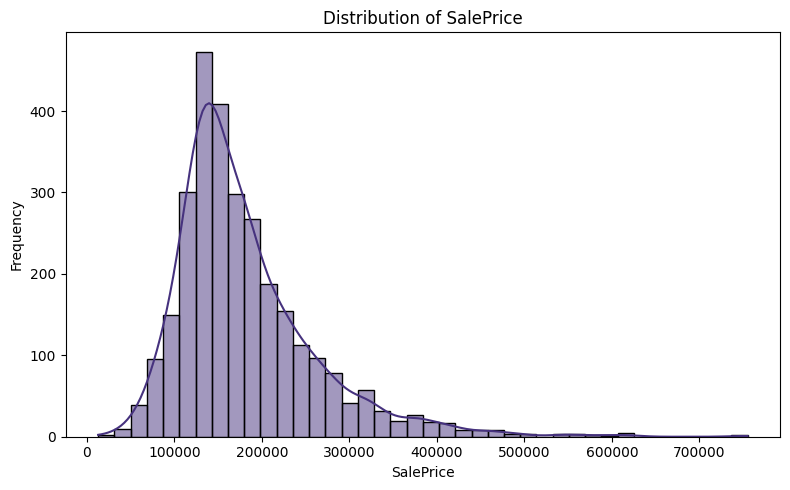

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(df["SalePrice"], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Boxplot

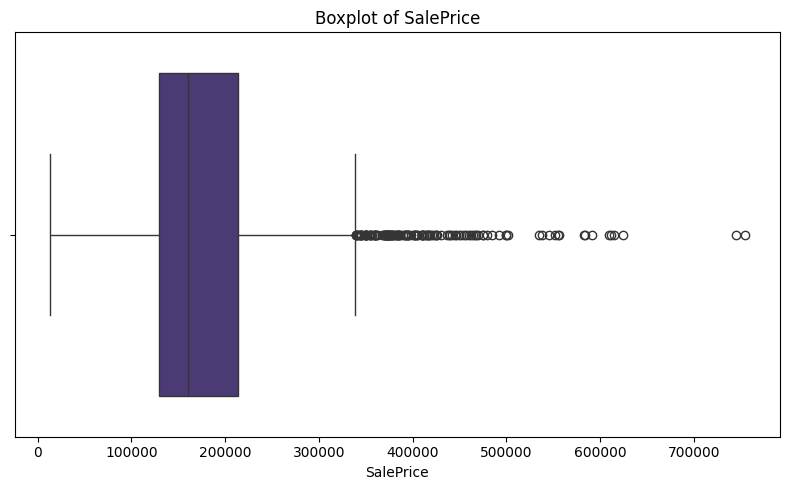

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["SalePrice"])
plt.title("Boxplot of SalePrice")
plt.xlabel("SalePrice")
plt.tight_layout()
plt.show()

The above plots shows:
- Sale price is right-skewed
- Most houses in our dataset sold for about 100000 and 200000
- Dataset has long tail of higher values with relavite few houses being that expensive (300,000–700,000+)
- Most common sale price (mode) is around 120,000–150,000.

TODO: log transform

We notice that there are a lot of missing data in some features from our dataset. Closer inspection to the features with the most missing values, we notice that in fact our parcer is over-zealous and is labelling data as missing where they are not necessarily. For example in `Mas Vrn Type` which labels the masonry veneer type of the property's wall could be actually "None". 

In addition, some features are conditional to the presence of other features. For example `Fireplace Qu` should only be considered as missing if the property actually has a fireplace. 

### Correlations

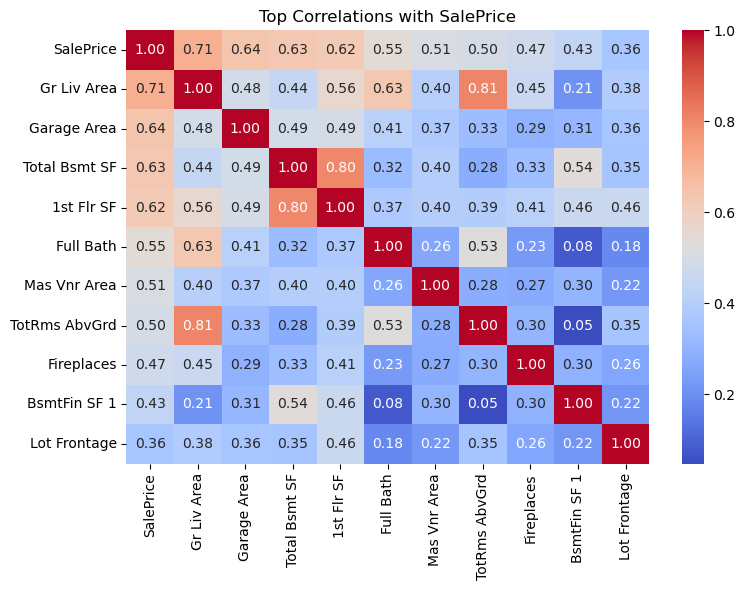

In [65]:
corr = df.corr(numeric_only=True)
top_corr = corr["SalePrice"].sort_values(ascending=False).head(11).index

plt.figure(figsize=(8,6))
sns.heatmap(df[top_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top Correlations with SalePrice")
plt.tight_layout()
plt.savefig("top_corr_heatmap.png")
plt.show()

<Axes: >

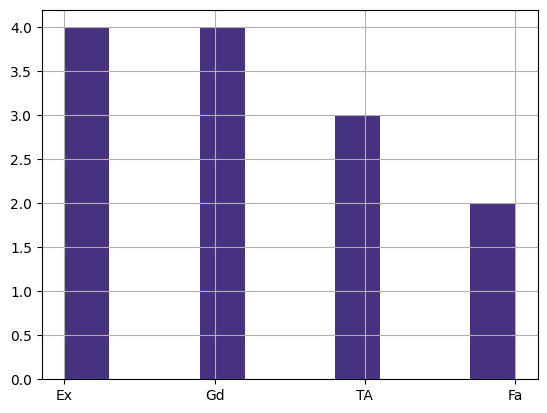

In [23]:
df['Pool QC'].hist()

## Exploratory Data Analysis

In this section we will use visualization techniques to gain an inside in our dataset.

In [32]:
# TODO: See what [this](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_ames_housing.html) guy is doing.
# He has nice plots

In [25]:
# TODO: Plot seasonality; i.e. number of sales against 'Date Sold'